<a href="https://colab.research.google.com/github/Loggo-MediCare/python-numpy-stock/blob/main/TSMC_(TSM)_5_Day_ARIMA_%2B_GARCH_Forecast_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4105744749.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSM", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/pytho


========== TSMC (TSM) - 5 Day Forecast ==========

            Forecast Price  Upper (+1σ)  Lower (-1σ)  Mean Return Forecast  \
2025-11-15      285.346824   291.369380   279.448754             -0.000729   
2025-11-16      285.816473   291.869666   279.888819              0.001645   
2025-11-17      286.071317   292.149930   280.119178              0.000891   
2025-11-18      286.394842   292.499681   280.417420              0.001130   
2025-11-19      286.696984   292.826965   280.695327              0.001054   

            Volatility Forecast (σ)  
2025-11-15                 0.020886  
2025-11-16                 0.020957  
2025-11-17                 0.021026  
2025-11-18                 0.021092  
2025-11-19                 0.021156  


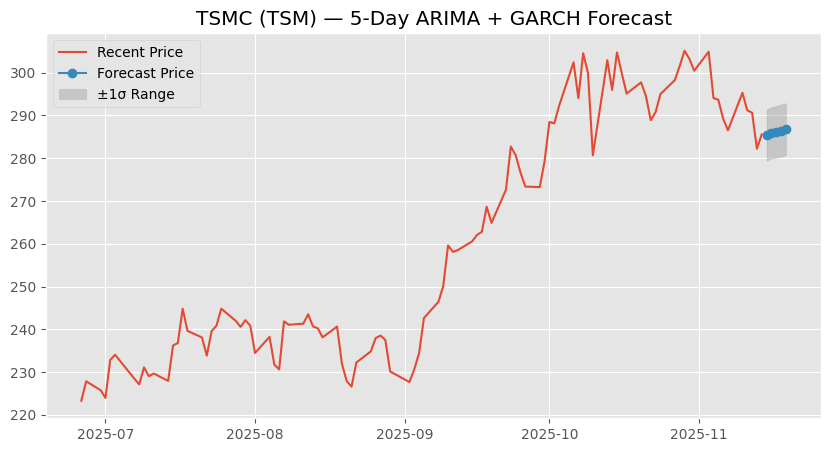

In [36]:
# ============================================
# TSMC (TSM) : 5-Day ARIMA + GARCH Forecast Demo
# Single Python Segment - Ready To Run
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Statsmodels & ARCH
import statsmodels.api as sm
from arch import arch_model

# --------------------------
# 1. 下載 TSMC (TSM) 股價資料
# --------------------------
df = yf.download("TSM", start="2018-01-01")
df = df[['Close']].dropna()
df.rename(columns={'Close': 'TSM'}, inplace=True)

# --------------------------
# 2. 計算 log return（報酬率）
# --------------------------
df['log'] = np.log(df['TSM'])
df['ret'] = df['log'].diff().dropna()
ret = df['ret'].dropna()

# --------------------------
# 3. 建立 ARIMA(1,0,1) 模型（平均報酬）
# --------------------------
arima_model = sm.tsa.ARIMA(ret, order=(1,0,1))
arima_res = arima_model.fit()

# 取殘差給 GARCH 用
arima_resid = arima_res.resid

# --------------------------
# 4. 建立 GARCH(1,1) 模型（波動度）
# --------------------------
garch_model = arch_model(arima_resid, p=1, q=1, vol='GARCH', dist='normal')
garch_res = garch_model.fit(update_freq=5, disp='off')

# --------------------------
# 5. 未來 5 天 — 預測平均報酬（ARIMA）
# --------------------------
arima_forecast = arima_res.forecast(steps=5)
mean_ret_forecast = arima_forecast.values

# --------------------------
# 6. 未來 5 天 — 預測波動度（GARCH）
# --------------------------
garch_forecast = garch_res.forecast(horizon=5)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1])

# --------------------------
# 7. 從報酬預測轉成「價格預測」
# --------------------------
last_price = df['TSM'].iloc[-1].item() # Extract scalar value

price_forecast = [last_price]
for i in range(5):
    next_price = price_forecast[-1] * np.exp(mean_ret_forecast[i])
    price_forecast.append(next_price)

price_forecast = price_forecast[1:]  # remove initial price

# --------------------------
# 8. 用波動度估算風險（±1σ 區間）
# --------------------------
upper = [p * np.exp(v) for p, v in zip(price_forecast, vol_forecast)]
lower = [p * np.exp(-v) for p, v in zip(price_forecast, vol_forecast)]

# --------------------------
# 9. 顯示結果
# --------------------------
forecast_df = pd.DataFrame({
    'Forecast Price': price_forecast,
    'Upper (+1σ)': upper,
    'Lower (-1σ)': lower,
    'Mean Return Forecast': mean_ret_forecast,
    'Volatility Forecast (σ)': vol_forecast
}, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5))

print("\n========== TSMC (TSM) - 5 Day Forecast ==========\n")
print(forecast_df)

# --------------------------
# 10. 畫圖
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(df['TSM'].tail(100), label='Recent Price')
plt.plot(forecast_df['Forecast Price'], label='Forecast Price', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Upper (+1σ)'], forecast_df['Lower (-1σ)'],
                 color='gray', alpha=0.3, label='±1σ Range')
plt.title("TSMC (TSM) — 5-Day ARIMA + GARCH Forecast")
plt.legend()
plt.show()

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1. 下載資料
# -------------------------
df = yf.download("TSM", start="2018-01-01")
df = df['Close'].dropna()  # 修正：將 'Adj Close' 改為 'Close'

# -------------------------
# 2. 計算報酬率
# -------------------------
returns = df.pct_change().dropna()

# -------------------------
# 3. 建立 ARIMA 模型 (短期趨勢)
# -------------------------
arima_model = ARIMA(returns, order=(1,0,1)).fit()
arima_forecast = arima_model.forecast(steps=5)

# ★★★ FIXED ★★★
arima_mean = arima_forecast.values     # 不用 arima_forecast[0]，避免 KeyError

# -------------------------
# 4. 建立 GARCH 模型 (波動度預測)
# -------------------------
garch_model = arch_model(returns, vol="Garch", p=1, q=1)
garch_result = garch_model.fit(disp='off')

garch_forecast = garch_result.forecast(horizon=5)
garch_vol = np.sqrt(garch_forecast.variance.values[-1])   # 取最後一期的預測波動度

# -------------------------
# 5. 輸出結果
# -------------------------
result = pd.DataFrame({
    "Day": [1,2,3,4,5],
    "ARIMA_Return_Forecast": arima_mean,
    "GARCH_Volatility_Forecast": garch_vol
})

print("TSMC 5-Day ARIMA-GARCH Forecast (Fixed Version)")
print(result)

[*********************100%***********************]  1 of 1 completed


TSMC 5-Day ARIMA-GARCH Forecast (Fixed Version)
   Day  ARIMA_Return_Forecast  GARCH_Volatility_Forecast
0    1              -0.000389                   0.021271
1    2               0.001855                   0.021338
2    3               0.001173                   0.021402
3    4               0.001380                   0.021464
4    5               0.001317                   0.021523


In [10]:
# 1. 安裝套件（在終端機或 Colab 裡執行一次）
!pip install yfinance pandas numpy matplotlib seaborn statsmodels scipy arch hvplot

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# statsmodels & scipy
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

# GARCH
from arch import arch_model

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 4)

# 下載 Micron (MU) 股價資料
start_date = "2019-01-01"
end_date = "2025-11-15"   # 自己改，或用 None 取到今天

mu = yf.download("TSM", start=start_date, end=end_date)
mu.head()

/tmp/ipython-input-144004100.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  mu = yf.download("TSM", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSM,TSM,TSM,TSM,TSM
Date,,,,,
2019-01-02,31.321569,31.518830,30.875588,31.047120,5273100
2019-01-03,29.469044,30.463924,29.391855,30.309546,15998000
2019-01-04,29.992208,30.043666,29.340389,29.554802,14178200
2019-01-07,30.215202,30.421041,29.992213,30.026517,6850800
2019-01-08,29.966482,30.172321,29.709186,30.112285,11462600


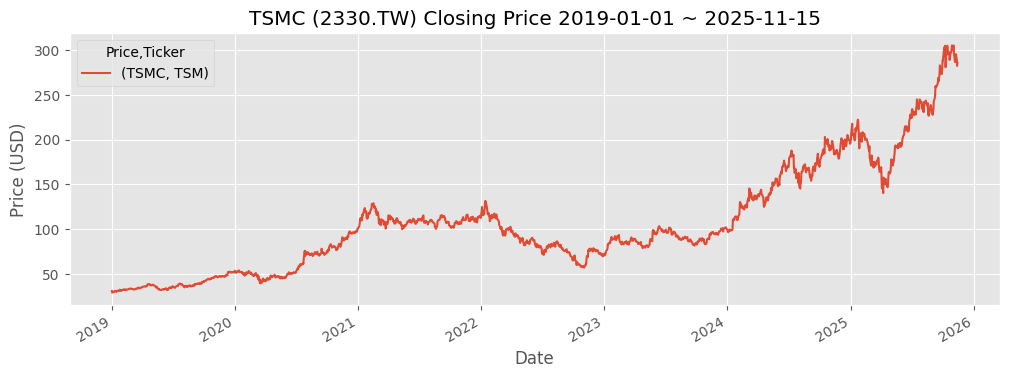

In [11]:
closing_price = mu[['Close']].rename(columns={'Close': 'TSMC'})

closing_price.plot(
    title=f"TSMC (2330.TW) Closing Price {start_date} ~ {end_date}",
    ylabel="Price (USD)"
)
plt.show()


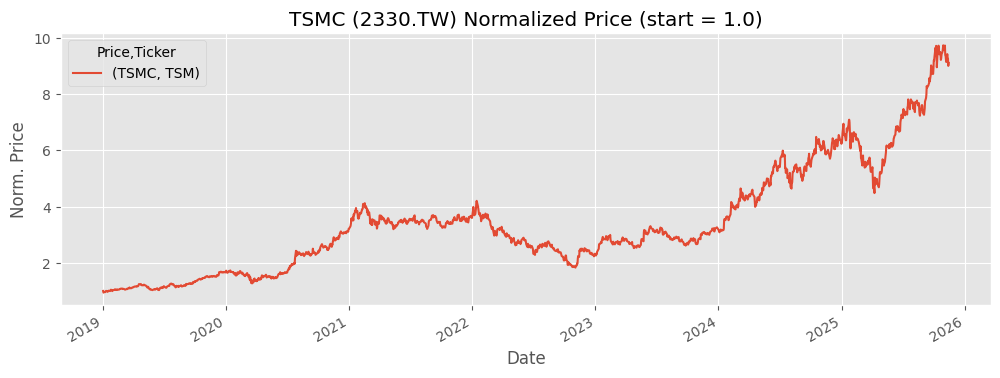

Price,TSMC
Ticker,TSM
Date,
2019-01-02,1.000000
2019-01-03,0.940855
2019-01-04,0.957558
2019-01-07,0.964677
2019-01-08,0.956736


In [14]:
closing_price_n = closing_price.div(closing_price.iloc[0])
fig_dims = (12, 4)

closing_price_n.plot(figsize=fig_dims,
                     title="TSMC (2330.TW) Normalized Price (start = 1.0)",
                     ylabel="Norm. Price")
plt.show()

closing_price_n.head()


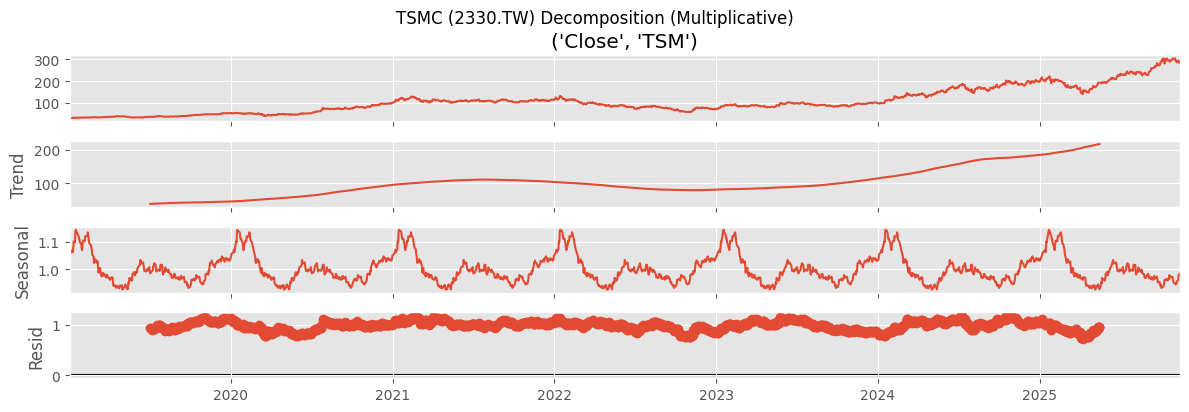

In [19]:
# 先確保 index 是 DatetimeIndex（yfinance 下載時通常已是）
# 直接從 mu 提取 'Close' 價格作為 Series
mu_close = mu[('Close', 'TSM')]

# 看一下圖，目測是「趨勢 + 可能有年季節性」→ 先試 multiplicative 模型
mu_decomp = seasonal_decompose(mu_close, model='multiplicative', period=252)  # 約一年交易日

mu_decomp.plot()
plt.suptitle("TSMC (2330.TW) Decomposition (Multiplicative)", y=1.02)
plt.show()

In [21]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'

    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test == 'kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'

    output_dict = {
        'Test Statistic': test_score,
        'p-value': pval,
        'Numbers of lags': lags,
        'decision': decision
    }
    for key, value in critical.items():
        output_dict[f"Critical Value ({key})"] = value

    return pd.Series(output_dict, name=test)


In [22]:
adf_output = adfuller(mu_close.dropna())
kpss_output = kpss(mu_close.dropna(), nlags="auto")

pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss')
], axis=1)


/tmp/ipython-input-3521318034.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_output = kpss(mu_close.dropna(), nlags="auto")


,adf,kpss
Test Statistic,0.606727,4.532222
p-value,0.98778,0.01
Numbers of lags,20,26
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.434184,0.739
Critical Value (5%),-2.863234,0.463
Critical Value (10%),-2.567672,0.347
Critical Value (2.5%),NaN,0.574


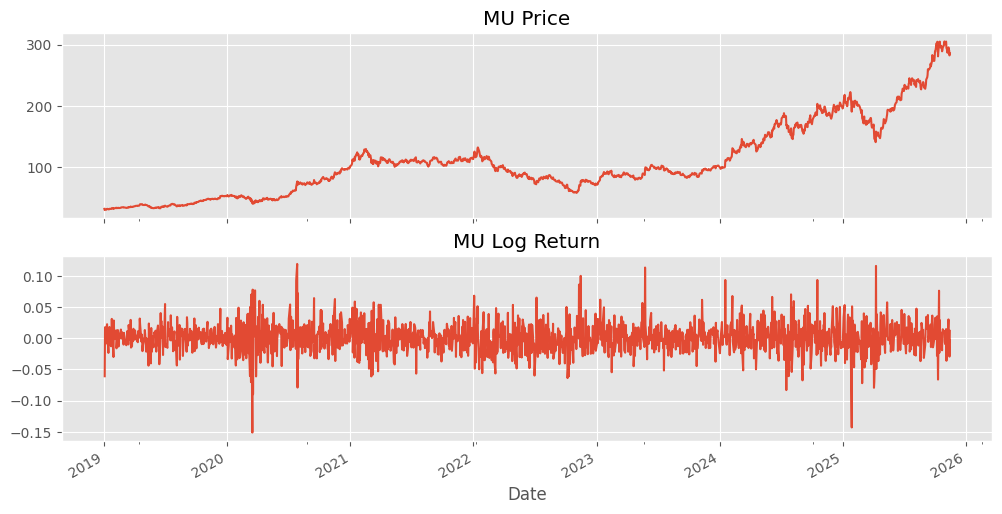

In [23]:
mu_log = np.log(mu_close)
mu_ret = mu_log.diff().dropna()  # log return ≈ 報酬率

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
mu_close.plot(ax=ax[0], title="MU Price")
mu_ret.plot(ax=ax[1], title="MU Log Return")
plt.show()


In [24]:
adf_ret = adfuller(mu_ret)
kpss_ret = kpss(mu_ret, nlags="auto")

pd.concat([
    print_results(adf_ret, 'adf'),
    print_results(kpss_ret, 'kpss')
], axis=1)


/tmp/ipython-input-521398631.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ret = kpss(mu_ret, nlags="auto")


,adf,kpss
Test Statistic,-8.41389,0.118147
p-value,0.0,0.1
Numbers of lags,25,5
decision,Stationary,Stationary
Critical Value (1%),-3.434198,0.739
Critical Value (5%),-2.86324,0.463
Critical Value (10%),-2.567675,0.347
Critical Value (2.5%),NaN,0.574


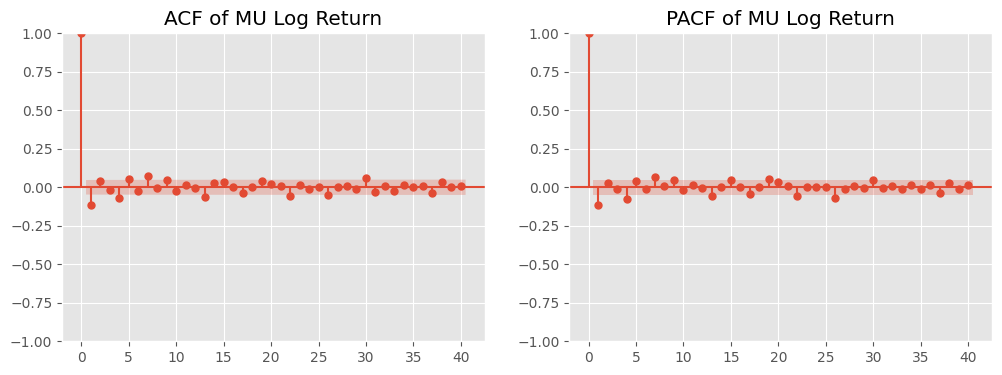

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(mu_ret, lags=40, ax=ax[0])
plot_pacf(mu_ret, lags=40, ax=ax[1])
ax[0].set_title("ACF of MU Log Return")
ax[1].set_title("PACF of MU Log Return")
plt.show()


In [26]:
lb = acorr_ljungbox(mu_ret, lags=10, return_df=True)
lb


,lb_stat,lb_pvalue
1,22.411416,2.200621e-06
2,24.910566,3.897080e-06
3,25.639502,1.134726e-05
4,33.550431,9.213644e-07
5,38.527724,2.955620e-07
6,39.707664,5.199117e-07
7,48.832907,2.446555e-08
8,48.848344,6.797820e-08
9,52.441184,3.729847e-08
10,53.523444,5.951708e-08


In [27]:
import statsmodels.api as sm

arma_model = sm.tsa.ARIMA(mu_ret, order=(1,0,1))
arma_res = arma_model.fit()
print(arma_res.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       ('Close', 'TSM')   No. Observations:                 1728
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4045.226
Date:                Fri, 14 Nov 2025   AIC                          -8082.452
Time:                        17:35:17   BIC                          -8060.633
Sample:                             0   HQIC                         -8074.381
                               - 1728                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.475      0.013       0.000       0.002
ar.L1         -0.3555      0.155     -2.293      0.022      -0.659      -0.052
ma.L1          0.2455      0.162      1.520      0.1

In [29]:
arma_resid = arma_res.resid


In [30]:
garch = arch_model(arma_resid, vol='Garch', p=1, q=1, dist='normal')
garch_res = garch.fit(update_freq=10)
print(garch_res.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4109.460141172105
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4109.46
Distribution:                  Normal   AIC:                          -8210.92
Method:            Maximum Likelihood   BIC:                          -8189.10
                                        No. Observations:                 1728
Date:                Fri, Nov 14 2025   Df Residuals:                     1727
Time:                        17:35:59   Df Model:                            1
                                  Mean Model                                 
  

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005422. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


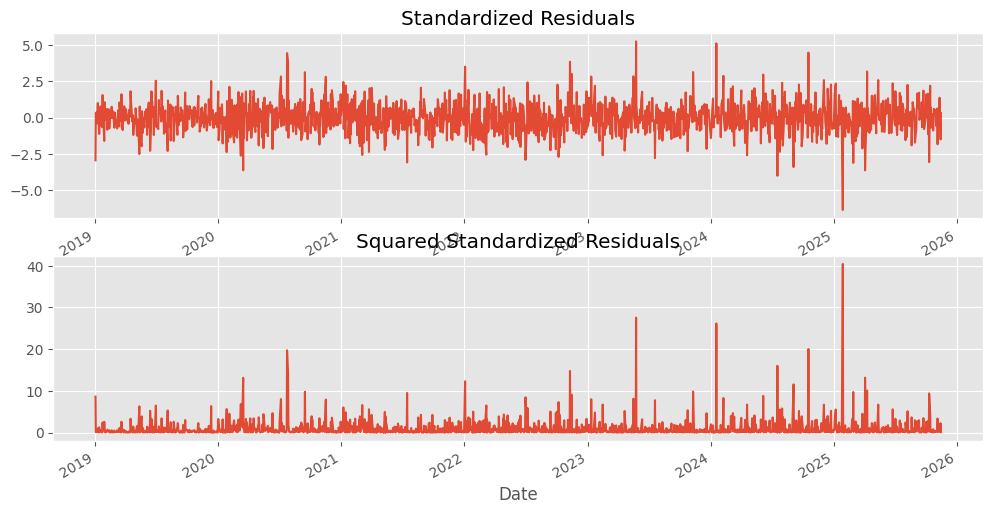

In [31]:
# Ljung-Box on standardized residuals
std_resid = garch_res.std_resid.dropna()
acorr_ljungbox(std_resid, lags=10, return_df=True)

# 畫圖看看
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
std_resid.plot(ax=ax[0], title="Standardized Residuals")
(std_resid**2).plot(ax=ax[1], title="Squared Standardized Residuals")
plt.show()


Best lambda: -0.24411729323602016


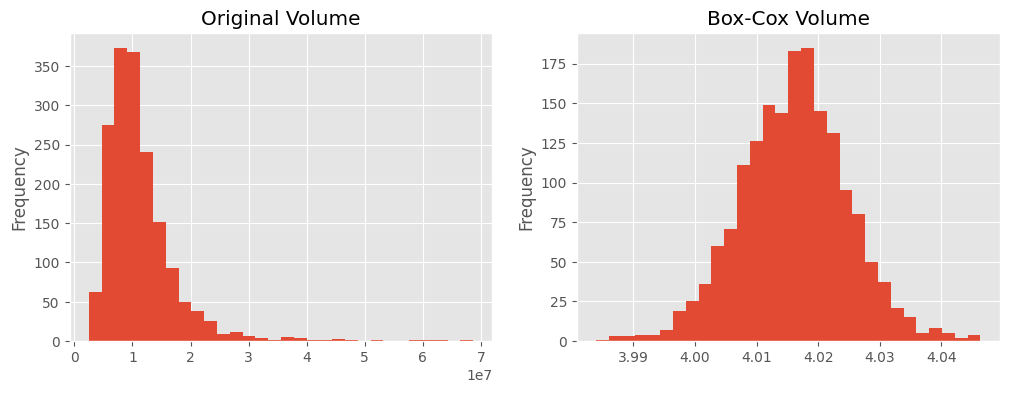

In [33]:
from scipy.stats import boxcox

volume = mu[('Volume', 'TSM')].dropna().astype(float)

xt, lam = boxcox(volume)
volume_bc = pd.Series(xt, index=volume.index)

print("Best lambda:", lam)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
volume.plot(kind='hist', bins=30, ax=ax[0], title="Original Volume")
volume_bc.plot(kind='hist', bins=30, ax=ax[1], title="Box-Cox Volume")
plt.show()